In [2]:
from pysat.formula import CNF
from pysat.solvers import Solver

# create a satisfiable CNF formula "(-x1 ∨ x2) ∧ (-x1 ∨ -x2)":
cnf = [CNF(from_clauses=[[1,-3]]), CNF(from_clauses=[[-1, 2], [-1, -2]])]

# create a SAT solver for this formula:
with Solver(bootstrap_with=cnf[0]) as solver:
    # 1.1 call the solver for this formula:
    print('formula is', f'{"s" if solver.solve() else "uns"}atisfiable')

    # 1.2 the formula is satisfiable and so has a model:
    print('and the model is:', solver.get_model())

    # 2.1 apply the MiniSat-like assumption interface:
    print('formula is',
        f'{"s" if solver.solve(assumptions=[1, 2]) else "uns"}atisfiable',
        'assuming x1 and x2')

    # 2.2 the formula is unsatisfiable,
    # i.e. an unsatisfiable core can be extracted:
    print('and the unsatisfiable core is:', solver.get_core())

formula is satisfiable
and the model is: [-1, -2, -3]
formula is satisfiable assuming x1 and x2
and the unsatisfiable core is: None


In [3]:
# 共 50 个变量
# 10000 个子句分配为每组 ratio*50 个
# 其中有 num_satisfied_clauses 组可满足的
# 占比为 num_satisfied_clauses*ratio*50/10000

# 随机生成3CNF

设定50个变量和10000个子句，利用随机数生成3CNF

In [1]:
from random import randint

num_variables = 50
num_clauses = 10000
clauses = []

for _ in range(num_clauses):
    clause = []
    clause_bin = bin(randint(0, 8-1))[2:]
    clause_bin = "0"*(3-len(clause_bin)) + clause_bin
    
    assert len(clause_bin)==3

    for cb in clause_bin:
        clause.append(randint(1,num_variables)*(-1)**int(cb))
    while len(clause) != len(set(clause)): # 当随机生成的数字重复
        clause = list(set(clause))
        clause.append(randint(1,num_variables))
    clauses.append(clause)

print(len(clauses))
print(clauses[0])

10000
[32, -22, -37]


In [2]:
from math import floor
from tqdm import tqdm
from pysat.formula import CNF
from pysat.solvers import Solver

ratio = 5
batch_size_clauses = int(ratio*num_variables)
num_batch = floor(num_clauses/batch_size_clauses)
num_satisfied_clauses = 0

batch_clauses = [clauses[i*batch_size_clauses:(i+1)*batch_size_clauses] for i in range(num_batch)]

loop = tqdm(batch_clauses)
# create a SAT solver for this formula:
for batch_clause in loop:
    with Solver(bootstrap_with=CNF(from_clauses=batch_clause)) as solver:
        if solver.solve():
            num_satisfied_clauses += 1
print(num_satisfied_clauses)
print(num_satisfied_clauses*batch_size_clauses/10000)

100%|██████████| 40/40 [00:00<00:00, 1666.66it/s]

7
0.175


In [7]:
import numpy as np
from random import randint
from copy import deepcopy
from tqdm import tqdm
from pysat.formula import CNF
from pysat.solvers import Solver

result = {}
max_num_clauses = 10000

for num_variables in [25, 50, 100]:#, 200]:#, 500]:
    x = []
    clauses = []
    num_batch = 100

    for _ in range(max_num_clauses):
        clause = []
        clause_bin = bin(randint(0, 8-1))[2:]
        clause_bin = "0"*(3-len(clause_bin)) + clause_bin
    
        assert len(clause_bin)==3

        for cb in clause_bin:
            clause.append(randint(1,num_variables)*(-1)**int(cb))
        while len(clause) != len(set(clause)):
            clause = list(set(clause))
            clause.append(randint(1,num_variables))
        clauses.append(clause)
    
    print(f"--{len(clauses)} clauses with variables {num_variables} generated successfully--")

    for ratio in tqdm(np.arange(3,6,0.01), desc="ratio"):
        batch_size_clauses = int(ratio*num_variables)
        num_clauses = num_batch*batch_size_clauses

        num_satisfied_clauses = 0

        batch_clauses = [clauses[100*i:100*i + batch_size_clauses] for i in range(num_batch-int(batch_size_clauses*num_batch/max_num_clauses))]

        # loop = tqdm(batch_clauses)
        for batch_clause in batch_clauses:
            with Solver(bootstrap_with=CNF(from_clauses=batch_clause)) as solver:
                if solver.solve():
                    num_satisfied_clauses += 1
        x.append([ratio, num_satisfied_clauses/num_batch])
    result[num_variables] = np.array(x)
    print(result[num_variables].shape)

--10000 clauses with variables 25 generated successfully--


ratio: 100%|██████████| 300/300 [00:07<00:00, 39.72it/s]


(300, 2)
--10000 clauses with variables 50 generated successfully--


ratio: 100%|██████████| 300/300 [00:15<00:00, 19.83it/s]


(300, 2)
--10000 clauses with variables 100 generated successfully--


ratio: 100%|██████████| 300/300 [00:37<00:00,  7.92it/s]

(300, 2)


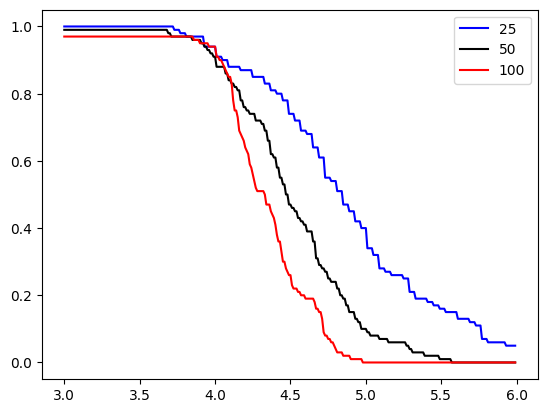

In [8]:
import matplotlib.pyplot as plt

color = {
    10: 'g',
    25: 'b',
    50: 'k',
    100: 'r',
    200: 'c',
    500: 'y'
}

for num_variable in result.keys():
    np.save(f"variable_{num_variable}.npy", "w")
    plt.plot(result[num_variable][:,0], result[num_variable][:,1], color[num_variable], label=num_variable)
plt.legend()
plt.show()

In [125]:
for key in result.keys():
    print(key, result[key].shape)

5 (25, 2)
10 (25, 2)
25 (25, 2)
50 (25, 2)


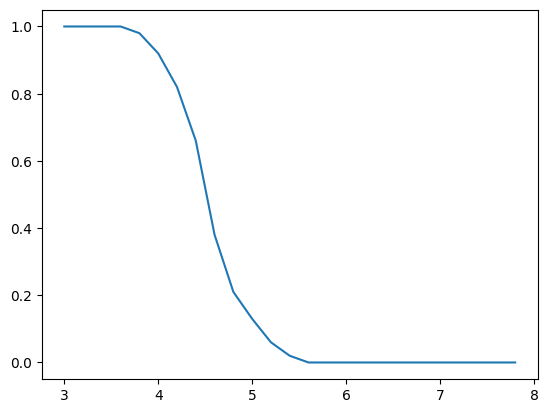

In [121]:
import matplotlib.pyplot as plt

x = np.array(x)

plt.plot(x[:,0], x[:,1])